In [49]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

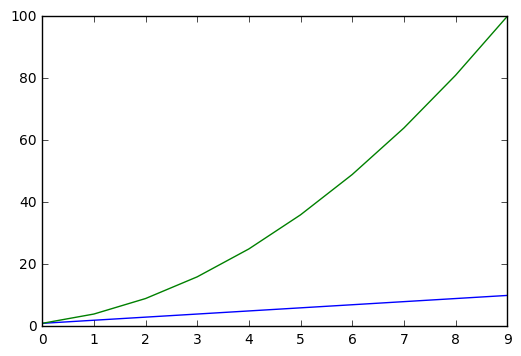

In [233]:
dist = stats.norm

Z = dist.rvs(size=200000).reshape(-1,2)

#L = np.random.rand(10,2)
#L = np.arange(20).reshape(10,2)
L = np.ones((1,2)) * np.arange(1,11)[:,None]
L[:,1] *= L[:,1]

X = (L @ Z.T).T

plt.plot(L[:,0])
plt.plot(L[:,1])

In [237]:
class FactorAnalyzer:
    '''
        Implementing single factor analysis model from following paper
            "The EM algorithm for mixtures of factor analyzers", Ghahrmani
        
        Naming convensions are used as in paper
            k: number of factors
            p: number of observed variables
                        
    '''
    
    def __init__(self):
        pass
        
    def fit(self, data, n_factors=3, iters=100, verbose=False):
        '''
        data: (instance x p) dimensional numpy array
        iters: number of iterations to run EM algo
        
        Model:
            z = Lambda @ x + Psi
        
        returns:
            Lambda: factor loading matrix (p x k)
            Psi: diagonal matrix
        
        '''
        ### Preprocessing
        # store vars
        X = data
        n, p = X.shape
        k = n_factors
        # demean data
        X = X - np.ones((n,1)) * X.mean(0)
        ### Initialize model params: Lambda, Psi
        Lambda = np.random.rand(p,k)
        mask = np.eye(p)
        Psi = mask*(np.random.rand(p,p)+.001)
        
        # misc
        I = np.eye(k)
        inv = np.linalg.inv
        ### Run EM
        XX = X[:,:,None] # n x p x 1 , for nasty tensor stuff...
        LL = [] # log likelihood history
        T = (0,2,1) # transpose order
        for i in range(iters):
            ### E - step
            Psi_i = (1/np.diag(Psi))*mask # easy inverse
            XXT = XX.transpose(T)
            beta = Lambda.T@(Psi_i - Psi_i@Lambda@\
                             inv(I + Lambda.T@Psi_i@Lambda)@\
                             Lambda.T@Psi_i) # k x p
            E_zx = beta @ XX #n x k x 1
            E_zxT = E_zx.transpose(T)
            E_zzx = I - beta@Lambda + \
                (beta @ (XX @ XXT) @ beta.T) # n x k x k
            ### Compute Log Likelihood
            ll = -(n/2)*np.linalg.det(Psi) - \
                ((.5*XXT@Psi_i@XX -XXT@Psi_i@Lambda@E_zx).squeeze() + \
                np.trace(Lambda.T@Psi_i@Lambda@E_zzx, \
                         axis1=1, axis2=2)).sum(0)
#             print(ll.shape)
#             pshape = lambda A: print(A.shape)
#             pshape(Lambda.T@Psi_i@Lambda@E_zzx)
#             pshape(np.trace(Lambda.T@Psi_i@Lambda@E_zzx, \
#                          axis1=1, axis2=2))
#             pshape(.5*XXT@Psi_i@XX -XXT@Psi_i@Lambda@E_zx)
            LL.append(ll)
            ### M - step
            Lambda = (XX@E_zxT).sum(0) @ inv(E_zzx.sum(0))
            Psi = mask * (XX@XXT - \
                          Lambda@E_zx@XXT).mean(0)
            ###
            if verbose and (i+1)%10==0:
                print("cycle {}, log-likelihood {}".format(i+1, ll))
        ###
        self.Lambda = Lambda
        self.Psi = Psi
        self.LL = LL
        return Lambda, Psi
        
    

In [252]:
class FactorAnalyzer:
    '''
        Implementing single factor analysis model from following paper
            "The EM algorithm for mixtures of factor analyzers", Ghahrmani
        
        Naming convensions are used as in paper
            k: number of factors
            p: number of observed variables
                        
    '''
    
    def __init__(self):
        pass
        
    def fit(self, data, n_factors=3, iters=100, verbose=False):
        '''
        data: (instance x p) dimensional numpy array
        iters: number of iterations to run EM algo
        
        Model:
            z = Lambda @ x + Psi
        
        returns:
            Lambda: factor loading matrix (p x k)
            Psi: diagonal matrix
        
        '''
        ### Preprocessing
        # store vars
        X = data
        n, p = X.shape
        k = n_factors
        # demean data
        X = X - np.ones((n,1)) * X.mean(0)
        ### Initialize model params: Lambda, Psi
        Lambda = np.random.rand(p,k)
        mask = np.eye(p)
        Psi = mask*(np.random.rand(p,p)+.001)
        
        # misc
        I = np.eye(k)
        inv = np.linalg.inv
        ### Run EM
        LL = [] # log likelihood history
        ll_max = 0
        for i in range(iters):
            ### E - step
            Psi_i = (1/np.diag(Psi))*mask # easy inverse
            beta = Lambda.T@(Psi_i - Psi_i@Lambda@\
                             inv(I + Lambda.T@Psi_i@Lambda)@\
                             Lambda.T@Psi_i) # k x p
            E_zx = beta @ X.T #k x n
            E_zzx = I - beta@Lambda + \
                (beta @ (X.T@X) @ beta.T) #k x k
            ### Compute Log Likelihood
            ll = (p/2)*np.log(2*np.pi)-(n/2)*np.linalg.det(Psi) - \
                ((.5*(X@Psi_i*X).sum() -(X@Psi_i@Lambda*E_zx.T).sum()) + \
                np.trace(Lambda.T@Psi_i@Lambda@E_zzx))
            if ll > ll_max:
                ll_max = ll
                self.Lambda = Lambda
                self.Psi = Psi
                self.i = i
            LL.append(ll)
            ### M - step
            Lambda = (X.T@E_zx.T) @ inv(E_zzx)
            Psi = mask * (X.T@X - \
                          Lambda@E_zx@X)/n
            ###
            if verbose:                
                print("cycle {}, log-likelihood {}".format(i+1, ll))
        ###
        self.LL = LL
        return self.Lambda, self.Psi

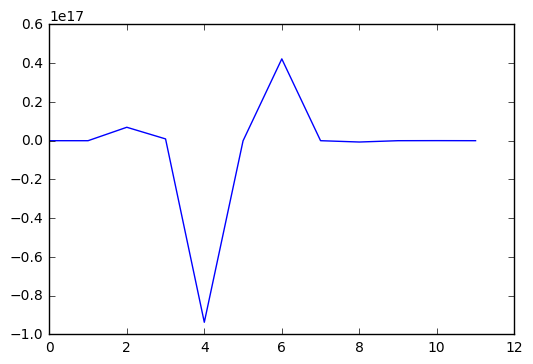

In [267]:
plt.plot(model.LL[:12])

cycle 10, log-likelihood -18006328835.831676
cycle 20, log-likelihood 1.7589624108915223e+18
cycle 30, log-likelihood 1.500708366803589e+19
cycle 40, log-likelihood 1.950378536535524e+17
cycle 50, log-likelihood 2.3898987734055892e+16
cycle 60, log-likelihood -1.5121622302889622e+16
cycle 70, log-likelihood 2.238707423668671e+18
cycle 80, log-likelihood 1.998830060035467e+20
cycle 90, log-likelihood -1.9465761759991693e+20
cycle 100, log-likelihood -6.143640865032729e+18


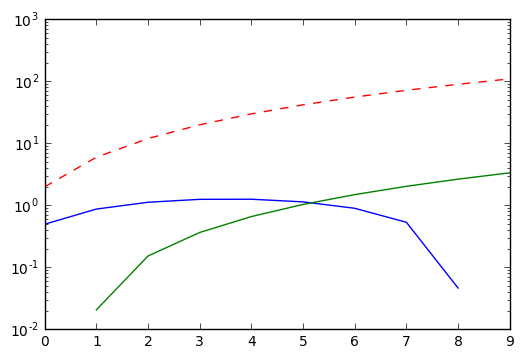

In [265]:
model = FactorAnalyzer()
Lam, P = model.fit(X, n_factors=2, iters=100, verbose=True)

plt.semilogy(Lam.T[0,:])
plt.semilogy(L.sum(1), 'r--')
plt.semilogy(Lam.sum(1))
#plt.plot(Lam.T[1,:])

In [261]:
from sklearn.decomposition import FactorAnalysis as FA
model = FA(n_components=2)
model.fit(X)
print(model.components_.T)

[[ -1.12835619e+00   8.49226338e-01]
 [ -4.23548911e+00   1.41683684e+00]
 [ -9.32139876e+00   1.70283151e+00]
 [ -1.63860851e+01   1.70721034e+00]
 [ -2.54295483e+01   1.42997335e+00]
 [ -3.64517881e+01   8.71120512e-01]
 [ -4.94528047e+01   3.06518445e-02]
 [ -6.44325980e+01  -1.09143266e+00]
 [ -8.13911681e+01  -2.49513299e+00]
 [ -1.00328515e+02  -4.18044916e+00]]


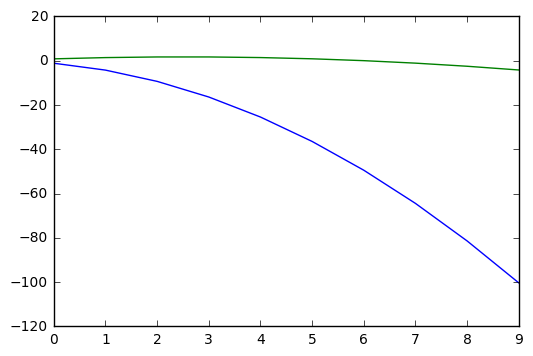

In [262]:
plt.plot(model.components_[0,:])
plt.plot(model.components_[1,:])

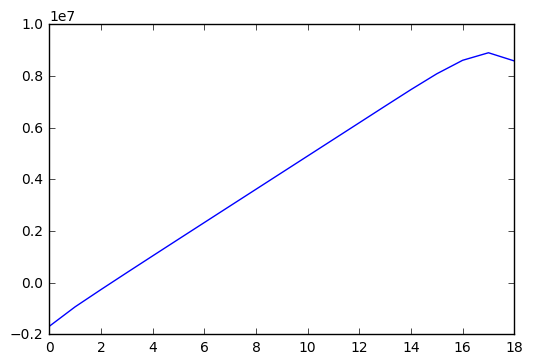

In [263]:
plt.plot(model.loglike_)

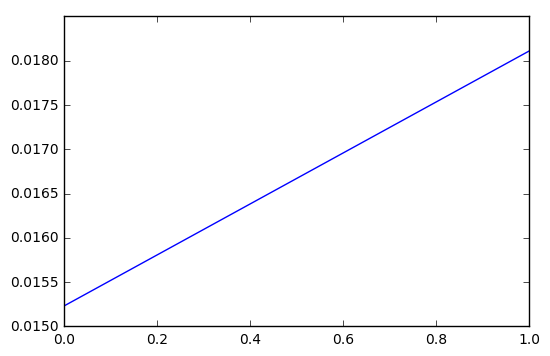

In [198]:
plt.plot(Lam[0,:])
#plt.plot(Lam[1,:])

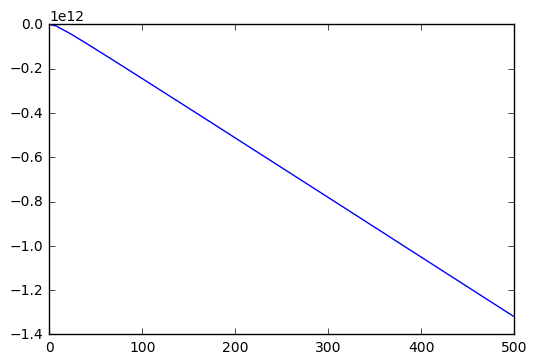

In [187]:
plt.plot(model.LL)

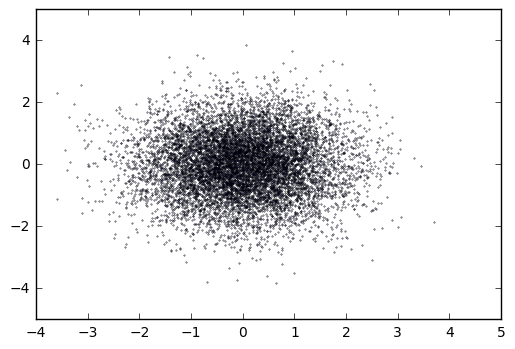

In [155]:
plt.scatter(*Z.T, s=.1)

In [147]:
print(L)

[[ 0.42115398  0.75108331]
 [ 0.67804021  0.83924501]
 [ 0.90155689  0.72277797]
 [ 0.50004749  0.68328146]
 [ 0.85247729  0.65178013]
 [ 0.87146738  0.72969152]
 [ 0.17494898  0.64706109]
 [ 0.98394198  0.56240209]
 [ 0.4950004   0.89223954]
 [ 0.17080712  0.61882018]]
